In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
from datasets.clock import ClockConfig, ClockDatasetConfig
from autoencoder.clock import get_dataloaders
from autoencoder.vis import load_model_script, load_model_state_dict, visualize_latent, visualize_predictions, visualize_reconstruction, print_model_parameters
from autoencoder.clock import eval_model
from models.autoencoders import MLPResnetAutoencoder
import torch
import torch.nn as nn
import sys
import os
import numpy as np
import functools

sys.path.append(os.path.join(os.getcwd(), '..'))


device = "cuda" if torch.cuda.is_available() else "cpu"


IMG_SIZE=128
BATCH_SIZE=128


def hand_width_scheduler(idx, slope=1e5):
  """
  Returns a value for hand width, ranging from ~0.2 to ~0.05
  """
  mean = -3 * torch.tensor(idx/slope).sigmoid()
  return np.random.lognormal(mean, 0.05)


dataloader, val_dataloader, _, _ = get_dataloaders(
  data_config=ClockConfig(
    hour_hand_width=0.1,
    minute_hand_width=0.1,
    # angle_quantization=2,
  ),
  dataset_config=ClockDatasetConfig(
    data_size=2**12,
    img_size=IMG_SIZE,
    augment=dict(
      noise_std=0.1,
    ),
    hand_width_scheduler=functools.partial(hand_width_scheduler, slope=1e5),
  ),
  # val_size=0,
  batch_size=BATCH_SIZE,
)

LATENT_DIM=2
type_ = "autoencoder"
model = load_model_state_dict(
  model_class = MLPResnetAutoencoder,
  img_size=IMG_SIZE,
  latent_dim=LATENT_DIM,
  name="MLPResnetAutoencoder-handwidth",
  postfix="d22q",
  checkpoint=4
)


In [2]:
eval_model(type_, model, [i for i in val_dataloader], device=device, latent_dim=LATENT_DIM, criterion=nn.SmoothL1Loss())

0.030852319207042456

# Encoders

In [3]:
visualize_predictions(type_, model, dataloader, latent_dim=LATENT_DIM)

Not encoder


# Decoders

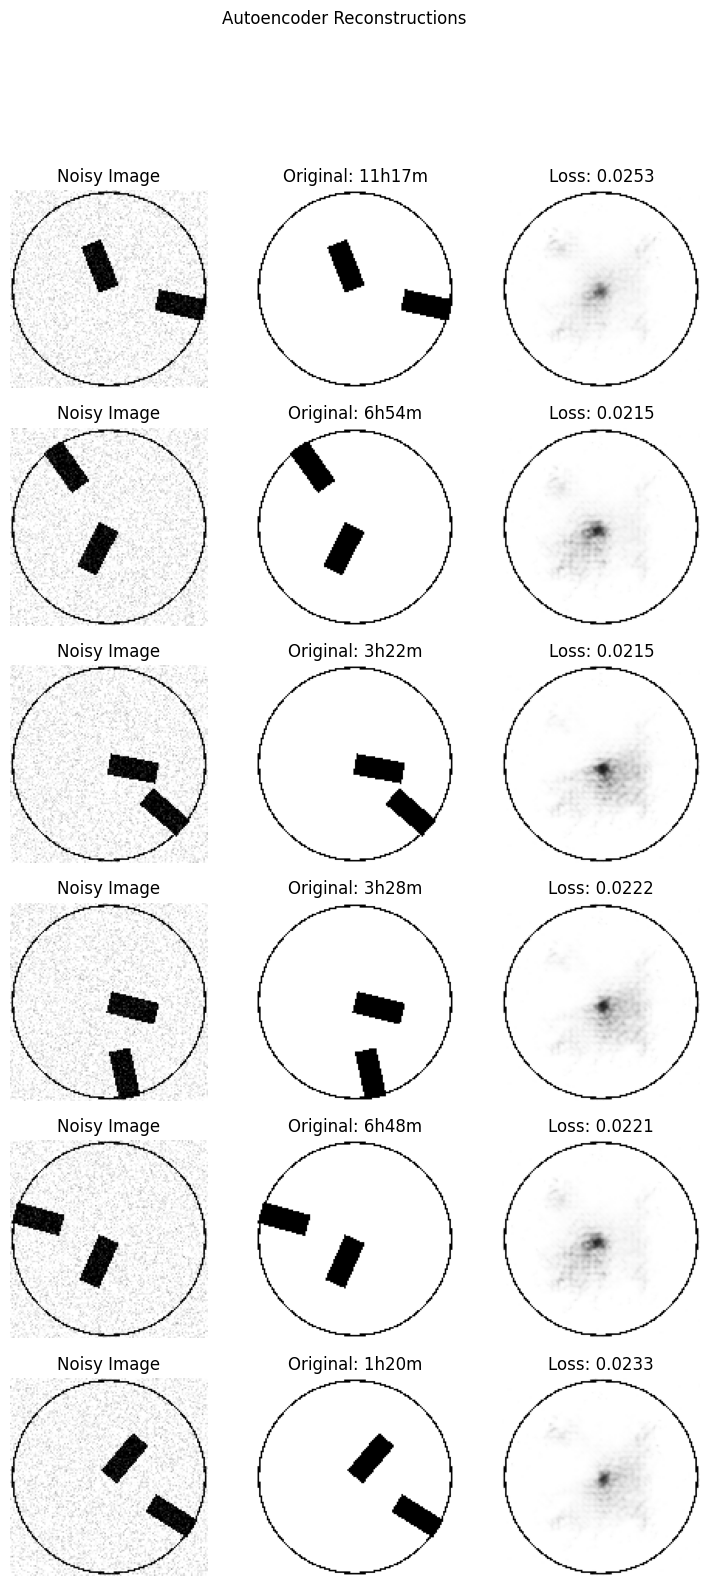

In [5]:
visualize_reconstruction(type_, model, dataloader, latent_dim=LATENT_DIM)

# Autoencoders

 69%|██████▉   | 11/16 [00:29<00:13,  2.64s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/MLPResnetAutoencoder-quantized/2-i128-d21q/11.pt'

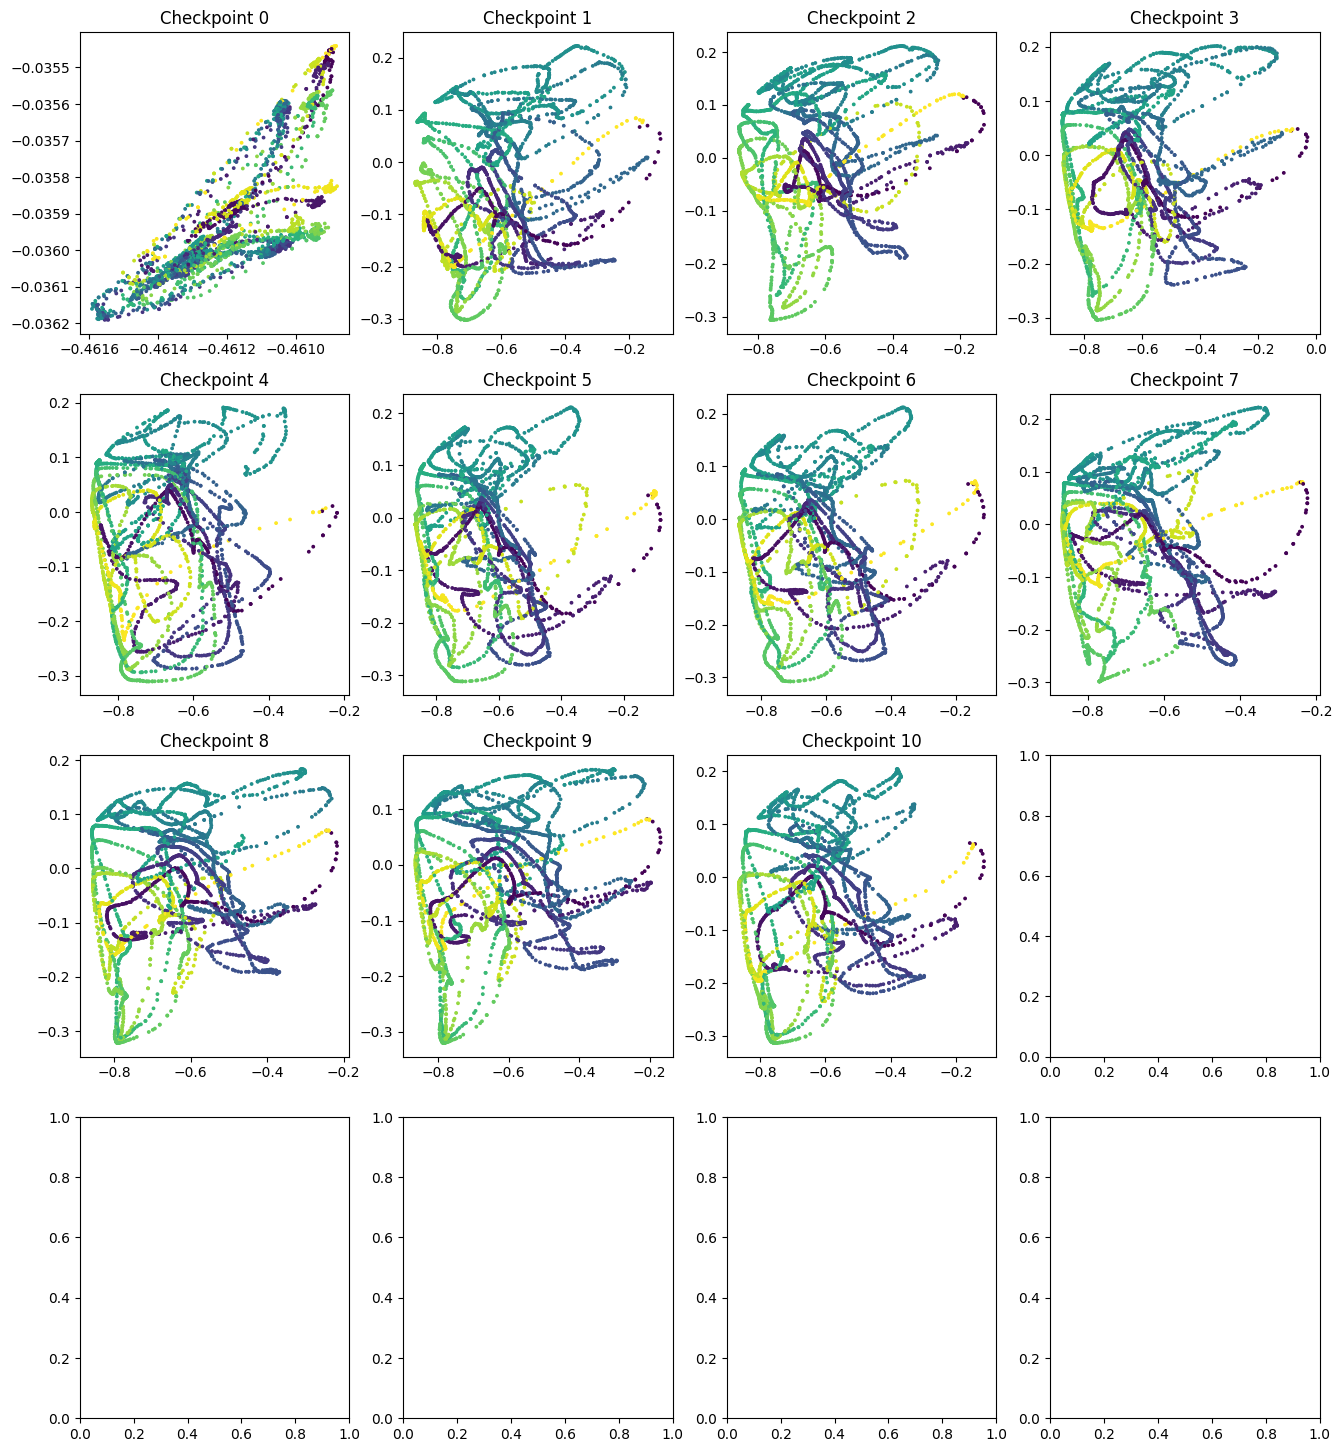

In [11]:
import json
from autoencoder.vis import load_model_state_dict, get_outputs
from autoencoder.clock import get_dataloaders
from datasets.clock import ClockConfig, ClockDatasetConfig
from models.autoencoders import MLPResnetAutoencoder
import matplotlib.pyplot as plt
import torch
import numpy as n
from tqdm import tqdm


IMG_SIZE=128
BATCH_SIZE=128

dataloader, val_dataloader, _, _ = get_dataloaders(
  data_config=ClockConfig(
    hour_hand_width=0.2,
    minute_hand_width=0.2,
  ),
  dataset_config=ClockDatasetConfig(
    data_size=2**12,
    img_size=IMG_SIZE,
  ),
  # val_size=0,
  batch_size=BATCH_SIZE,
)

LATENT_DIM=2

fig, ax = plt.subplots(4, 4, figsize=(16, 18))

for i in tqdm(range(16)):
  model = load_model_state_dict(
    model_class = MLPResnetAutoencoder,
    model_args=dict(
      encoder_args=dict(
        fc_size=512,
      ),
      decoder_args=dict(
        resnet_start_channels=384,
        fc_size=1024,
        conv_start_channels=64,
      ),
    ),
    img_size=IMG_SIZE,
    latent_dim=LATENT_DIM,
    name="MLPResnetAutoencoder-quantized",
    postfix="d21q",
    checkpoint=i
  )
  
  latents = []
  labels1d = []
  for _, label1d, _, latent, _ in get_outputs(type_, model, dataloader):
    latents.append(latent.unsqueeze(0).cpu())
    labels1d.append(label1d.unsqueeze(0).cpu())
    
  latents = torch.cat(latents, dim=0)
  labels1d = torch.cat(labels1d, dim=0)
  
  ax[i//4, i%4].scatter(latents[:, 0], latents[:, 1], c=labels1d, cmap="viridis", s=3)
  ax[i//4, i%4].set_title(f"Checkpoint {i}")
  
plt.suptitle("Latent Space Visualization at Different Checkpoints")
plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()


100%|██████████| 16/16 [00:39<00:00,  2.49s/it]


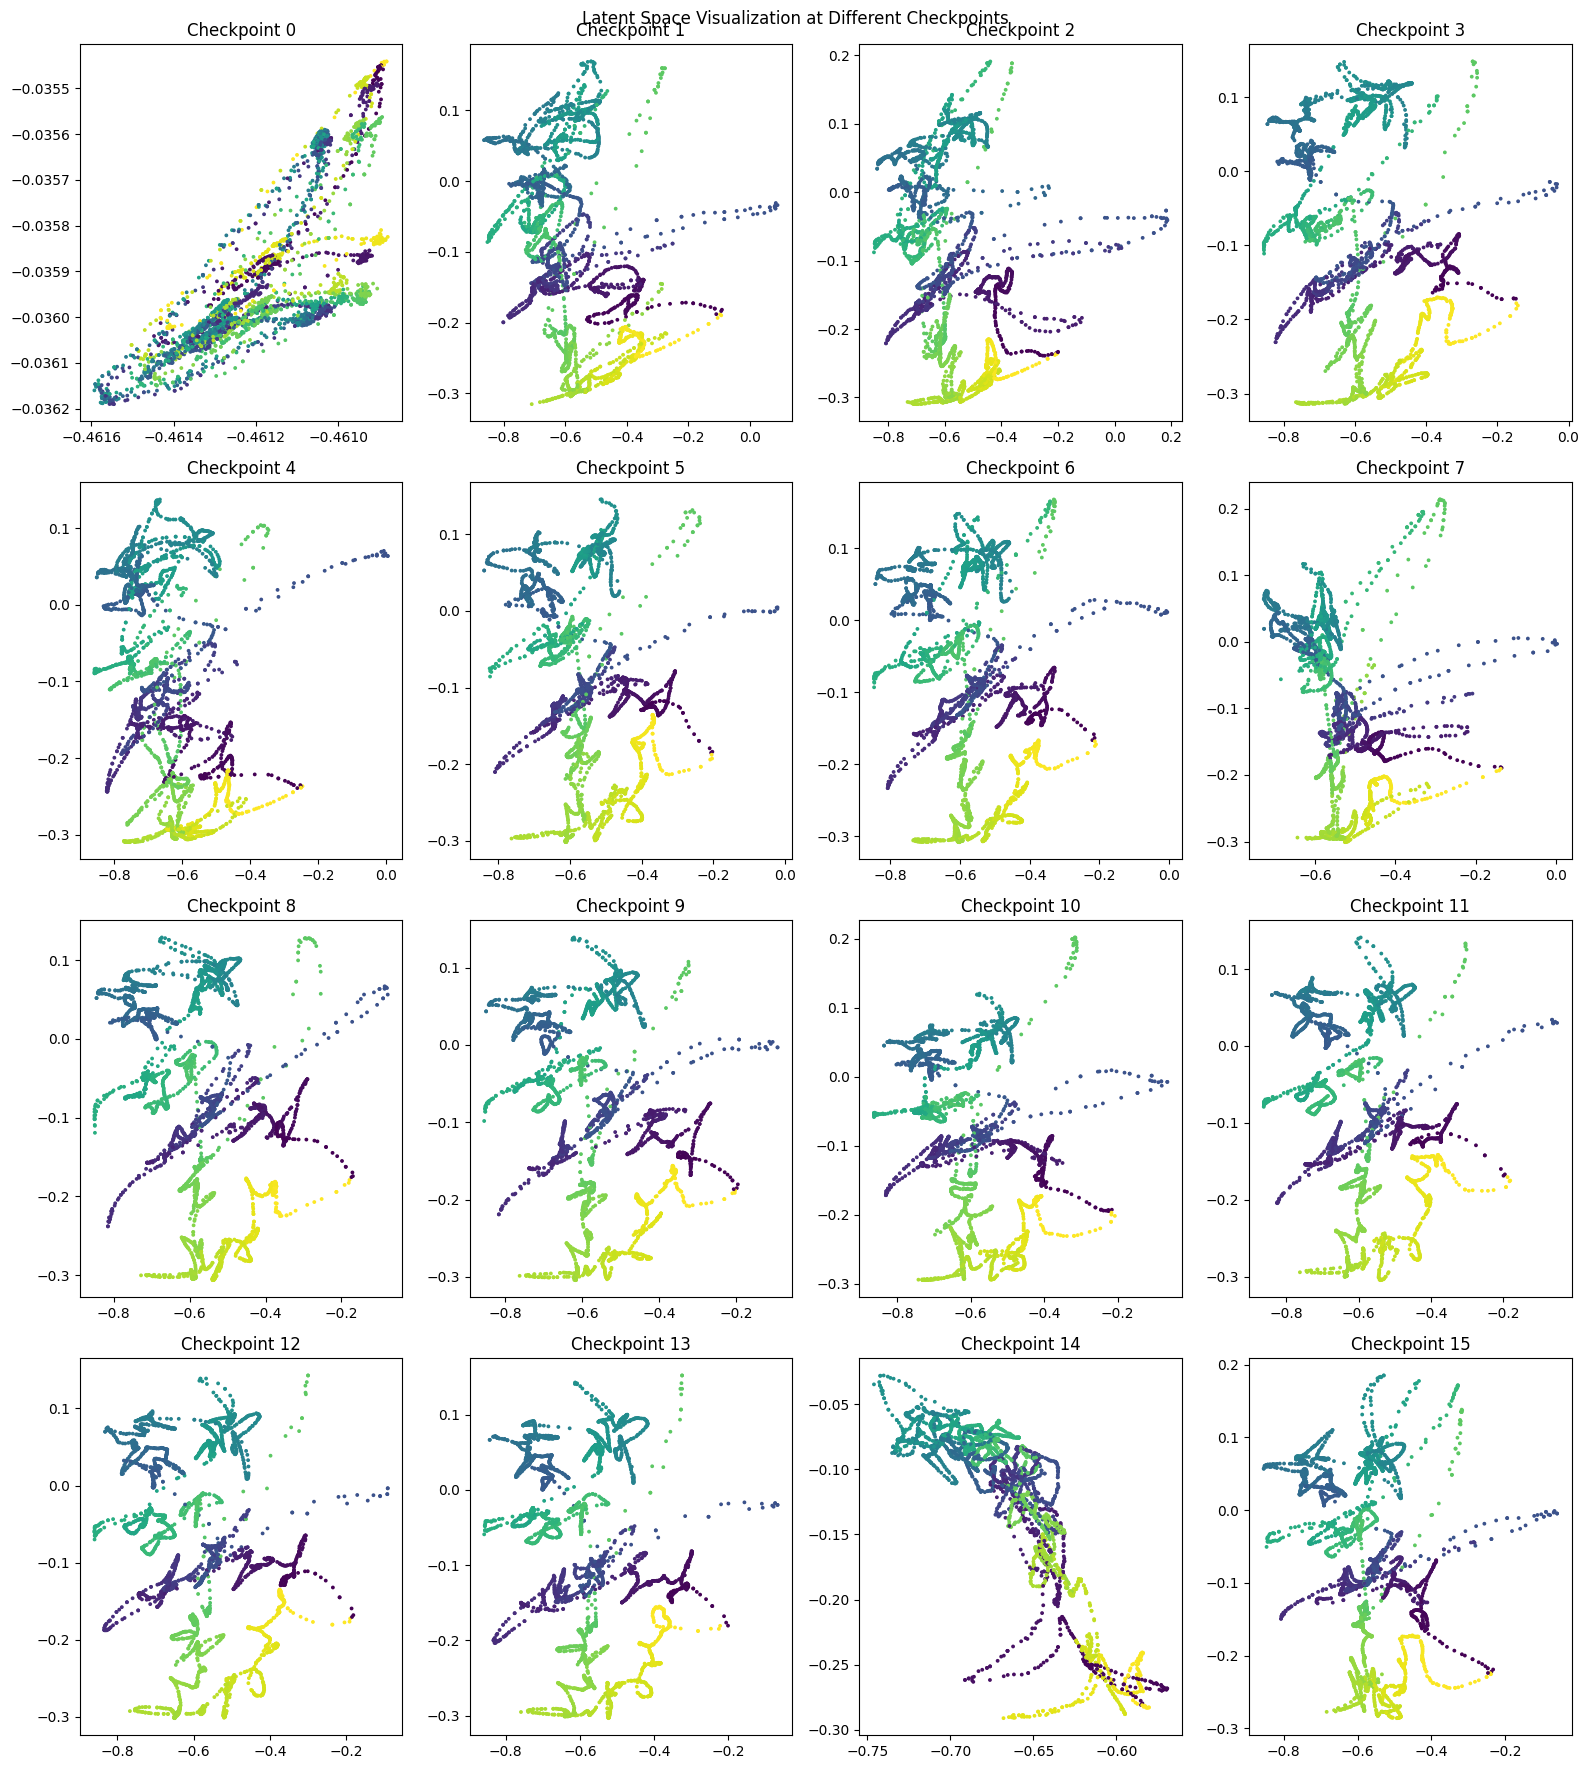